In [199]:
import matplotlib.pyplot as plt
import numpy as nm
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split

In [200]:
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'

# Import data
complete_df = pd.read_csv(f"{folder}CHEMBL2971_Ki.csv", sep=",")

# complete_df.fillna(complete_df.mean(), inplace=True)

In [201]:
smiles_list = complete_df['smiles']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]
scaffold_smiles = [Chem.MolToSmiles(scaffold) for scaffold in scaffolds]
scaffold_smiles = list(map(str, scaffold_smiles))

In [202]:
# Fingerprint aanmaken
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]
complete_df.to_csv(f"{folder}chembl234_ki.csv", sep=',', index=False)

In [203]:
complete_df['ecfp_bit_vectors'].iloc[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [204]:
def get_unique_scaffolds(scaffold_smiles):
    unique_scaffolds = []
    for scaffold in scaffold_smiles:
        if scaffold not in unique_scaffolds:
            unique_scaffolds.append(scaffold)
    return unique_scaffolds

list_unique_scaffolds=get_unique_scaffolds(scaffold_smiles)

location_scaffolds = defaultdict(list)
for scaffold in scaffold_smiles:
    location_scaffolds[scaffold].append(scaffold)

def location_similar_scaffolds(lijst):
    locations = defaultdict(list)
    for index, item in enumerate(lijst):
        if lijst.count(item) > 1:
            locations[item].append(index)
    return dict(locations)

locations_similar_scaffolds = location_similar_scaffolds(scaffold_smiles)

df_scaffolds_grouped = pd.DataFrame(columns=['Compound', 'Scaffold', 'Recurring'])
rows=[]
symbol_mapping = {}
symbol_counter = 0

for i, compound in enumerate(smiles_list):
    scaffold = scaffold_smiles[i]

    if scaffold in locations_similar_scaffolds:
        if scaffold not in symbol_mapping:
            symbol_counter += 1
            symbol_mapping[scaffold] = symbol_counter

        recurring_symbol = symbol_mapping[scaffold]
        recurring = True
    else:
        recurring_symbol = 0
        recurring = False
    row = [compound, scaffold, recurring_symbol]
    rows.append(row)

df_scaffolds_grouped = pd.DataFrame(rows, columns=['cpd_smiles', 'spd_scaffold', 'recurring_scaffold'])

#Toevoegen van extra data die nodig is voor de modellen
df_scaffolds_grouped.insert(0,'y',complete_df['y'])
# df_scaffolds_grouped.insert(1,'ecfp_bit_vectors',complete_df['ecfp_bit_vectors']) 
df_scaffolds_grouped['ecfp_bit_vectors'] = complete_df['ecfp_bit_vectors'].apply(lambda x: ''.join(str(i) for i in x))

df_scaffolds_grouped_sorted = df_scaffolds_grouped.sort_values('recurring_scaffold', ascending=False)

df_scaffolds_grouped_sorted.to_csv(f"{folder}scaffold_split_test.txt", sep='\t', index=False)


In [205]:
total_length_compounds = len(complete_df)
size_train_set = total_length_compounds * 0.8 # Uitgaande van idealiter een 0.8:0.2 verhouding tussen train en test

In [206]:
# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_test.txt", sep="\t")

#import random
# Data selecteren om een vergelijkbare data grootte te creeeren
#random_indices = random.sample(range(len(complete_df)), 379)
#complete_df = complete_df.iloc[random_indices]

complete_df['ecfp_bit_vectors'] = complete_df['ecfp_bit_vectors'].apply(lambda x: [int(i) for i in x])

In [207]:
# Creeer een DF voor alle scaffolds die uniek zijn
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'y']]

# Extraheer de X en Y value van de nieuwe DF 
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
y_unique = df_unique_scaffolds['y'].values

In [208]:
# Creeer een DF voor alle scaffolds die meermaals voorkomen
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'y', 'recurring_scaffold']]

# Extraheer de X, Y en Z value van de nieuwe DF
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup een eigen numerieke waarde
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist())
y_grouped = df_grouped_scaffolds['y'].values
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist()
print(x_grouped)

#df_grouped_scaffolds_indexes = df_grouped_scaffolds.groupby('recurring_scaffold')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [209]:
size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)
print(size_train_set_grouped_scaffolds)

479


In [210]:
# Creeeren van lege lijsten voor de Grouped Scaffolds
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

In [211]:
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else: 
        remaining = len(z_grouped)-x
        break
        
for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

In [212]:
print(len(x_train_grouped))
print(len(x_test_grouped))
print(y_train_grouped[0:5])
print(y_test_grouped[0:5])

479
120
[-2.041392685158225, -1.5314789170422551, -1.5563025007672873, -2.6434526764861874, -2.690196080028514]
[-0.1072099696478683, -0.1367205671564068, -0.2600713879850748, -0.1398790864012364, -0.4329692908744057]


In [213]:
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

In [214]:
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

In [215]:
y_train_grouped[0]
y_train_unique[0]

-2.800001827817969

In [216]:
x_train = nm.concatenate((x_train_grouped, x_train_unique))
x_test = nm.concatenate((x_test_grouped, x_test_unique))

y_train = nm.concatenate((y_train_grouped, y_train_unique))
y_test = nm.concatenate((y_test_grouped, y_test_unique))

In [217]:
print('TRAIN DATA')
print('y_train', len(y_train), y_train)
print('x_train', len(x_train), x_train)

print('TEST DATA')
print('x_test', len(x_test), x_test)
print('y_test', len(y_test), y_test)

TRAIN DATA
y_train 780 [-2.04139269e+00 -1.53147892e+00 -1.55630250e+00 -2.64345268e+00
 -2.69019608e+00 -1.97772361e+00 -1.32221929e+00 -1.14612804e+00
 -1.63346846e+00 -1.41497335e+00 -1.36172784e+00 -1.34242268e+00
 -2.17609126e+00 -3.32221929e+00  6.38272164e-01  1.87086643e-01
  5.55173278e-02  6.04807474e-02  2.67606240e-01  1.07905397e-01
  1.93820026e-01  3.62121727e-02  8.77392431e-03 -2.83301229e-01
 -6.44579892e-02  1.30768280e-01  1.24938737e-01 -2.14843848e-01
 -4.45604203e-01  5.06099934e-02  9.15149811e-02 -2.47973266e-01
  1.19186408e-01  6.55015488e-02  7.57207139e-02  1.48741651e-01
 -3.59835482e-01 -1.61368002e-01  2.59637311e-01  7.57207139e-02
 -5.14547753e-01 -8.27853703e-02  2.92429824e-01 -1.52288344e-01
 -9.69100130e-02 -4.18301291e-01 -3.83815366e-01 -3.34453751e-01
 -2.11892991e-02 -4.32137378e-03 -2.92256071e-01 -2.57678575e-01
 -3.46352974e-01 -4.01400541e-01  5.52841969e-01  6.38272164e-01
  5.08638306e-01  6.77780705e-01  6.98970004e-01 -4.53229788e-02
 -

In [218]:
# Fit Regressor
model = SVR(C=1, epsilon=0.1, kernel='rbf')
model.fit(x_train,y_train)

# Predict Test result
y_pred  = model.predict(x_test)

In [219]:
# Errors berekenen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae=mean_absolute_error(y_test, y_pred)
print('mean absolute error is ', mae)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('mean squared error is ', mse)

# Root Mean Squared Error
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
r2 = r2_score(y_test, y_pred)
print('r2 is', r2)

mean absolute error is  0.2613846082863575
mean squared error is  0.20036961864093153
root mean squared error is  0.44762665095024395
r2 is 0.8801144015398282


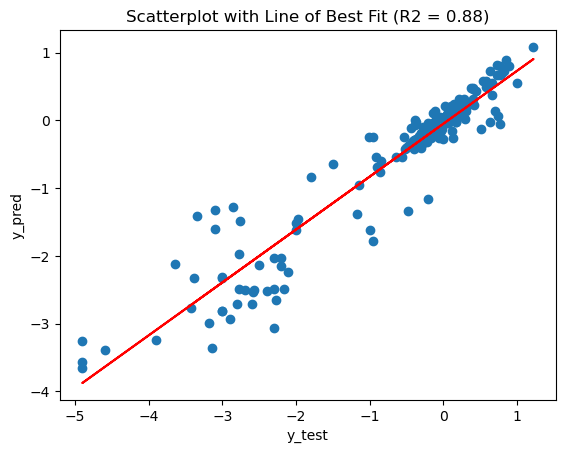

In [220]:
# R2 Visualisatie
plt.scatter(y_test,y_pred)
plt.plot(y_test, line, color='red', label='line of current best fit')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()